In [1]:
import numpy as np 
import networkx as nx
from tqdm import tqdm as tqdm 
from matplotlib import pyplot as plt
import timeit
from itertools import combinations
from joblib import Parallel, delayed

To recap what the article says:
1. You can make a directed navigable graph  with in-degree=out-degree = sqrt(n log n)
2. The construction is easy. For each node i,
- you add all the edges (j, i) for the m closest nodes, for m = sqrt(n log n)
- you add m=sqrt(n log n) random edges (i, j) [in the paper they don't call this m but I do].
Whp. the graph is navigable with length = 2. You can also make this construction deterministic.
The construction is based on property (1) in the paper, which is equivalent to navigability.
3. There is an almost tight LB. They create a graph with average degree almost sqrt(n), in the Euclidean space, with d > log n.

How can we improve? It would be interesting to see whether we can show that relaxing navigability can reduce by a lot the degree. For example, what if there is not a path from *every* source to every destination?
1. Then one candidate algorithm is to select k random initial points and then try to find a navigable path.
- A candidate construction, would be the one above, with a smaller value of incoming and outgoing edges, e.g., log n. Would then the power of k choices work?
2. We could even try this experimentally. Take their LB construction and try the construction with smaller m.
3. Another idea is to change the navigation algorithm. What if instead of visiting the closest node you visit the 2 (or higher) closest nodes and you check their nodes and you take the min or the 2 minima?
4. What if, when you are stuck, you are allowed to visit a further node? How many times do you have to follow a worse node?
Again, these can be tried first with their construction.

In [2]:
# Defining some utilities (early implementation, will be refactored in a class)
def uniformD(N,
             C):
    
    d = C*np.log(N)
    return np.random.choice([-1,1], size = (int(N),int(d)))

def randomEnvironment(n: int,
                      d: int):
    
    return np.random.multivariate_normal(np.zeros(d),
                                         np.eye(d),
                                         n)

def distanceBasedPermutation(x: np.array, 
                             ord = 2):
    
    DBP = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            DBP[i,j] = np.linalg.norm(x[i] - x[j], ord)

    return np.argsort(DBP, 1)

def randomizedConstruction(x: np.array,
                           ord = 2,
                           m = None,
                           scheme = 'paper'):

    n = x.shape[0]
    A = np.zeros((n,n))

    DBP = distanceBasedPermutation(x, ord)
    if not m:
        m = int(np.floor(np.sqrt(3 * n * np.log(n))))

    for i in range(n):

        # Deterministic step
        A[i, DBP[i, 1:m]] = 1
        
        # Randomized step
        if scheme == 'paper':
            S = int(np.ceil(3 * n * np.log(n)/m))
        else:
            S = m
            
        R = np.random.choice(np.concatenate([np.arange(0,i), np.arange(i+1,n)]), S)

        A[i, R] = 1

    return A


_________

In [3]:
def compute_distance_adjacency_matrix(X):

    sq_X = np.sum(X**2, axis=1, keepdims=True)
    dist_matrix = np.sqrt(sq_X - 2 * np.dot(X, X.T) + sq_X.T)
    dist_matrix[np.isnan(dist_matrix)] = 0
    
    return dist_matrix

In [4]:
# Greedy routing algorithm (vectorized)

def greedyRoutingVec(
        x: np.array,
        A: np.array
        ):
    
    N = x.shape[0]
    done = False

    all_pairs = list(combinations(range(N),2))
    all_pairs_ = np.zeros((2,len(all_pairs)), dtype='int32')

    for i in range(len(all_pairs)):

        all_pairs_[0,i] = all_pairs[i][0]
        all_pairs_[1,i] = all_pairs[i][1]

    S = np.copy(all_pairs_[0,:])
    T = np.copy(all_pairs_[1,:])

    # Precomputing the distance matrix masked by the adjacencies
    sqX = np.sum(x**2, axis=1, keepdims=True)
    D = np.sqrt(sqX - 2 * np.dot(x, x.T) + sqX.T) 
    D[np.isnan(D)] = 0
    D = D * A
    D[D == 0] = np.inf
    
    all_pairs_ = np.row_stack([all_pairs_, np.zeros(all_pairs_.shape[1])])

    steps = np.zeros(all_pairs_.shape[1])

    while not done:
        
        if np.all(A[S,] == 0):
            break

        else:

            D_ = np.copy(D[:,T])
            H = np.argmin(D_, axis = 1)

            ids = np.where(np.linalg.norm(x[T,] - x[H,], axis = 1) < np.linalg.norm(x[T,] - x[S,], axis = 1))[0]
            S[ids] = H[ids]
            steps[ids] += 1

            if np.all(S == T):
                done = True
                break

            if len(ids) == 0:
                break
            
    return S, done, steps

In [5]:
# Greedy routing algorithm

def greedyRouting(s: int,
                  t: int,
                  x: np.array,
                  A: np.array
                  ):
    
    done = False
    j = s

    steps = 0

    while not done:
        
        if np.all(A[j] == 0):
            done = True

        else:
            neighs = np.where(A[j,:] == 1)[0]
            X_ = np.copy(x[neighs])
            h = neighs[np.argmin(np.linalg.norm(X_ - x[t], axis = 1))]

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):
                j = h
                steps += 1
                
            else:
                done = True


    return j, steps

In [6]:
X = uniformD(100, 10)
A = randomizedConstruction(X)

s = np.random.randint(0,X.shape[0])
t = np.random.randint(0,X.shape[0])

X1, steps = greedyRouting(s, t, X, A)
print(np.all(X1 == t))
print(steps)

True
1


Paper baseline is ok, now let's try to work out something sharper with a sparser graph. 

________

First simulation: 
+ Slightly modify the paper construction, considering $m$ closest nodes in the deterministic step and $m$ random nodes in the stochadtic one;
+ Perform the construction and perform random source-target greedy algorithm
+ Do it for all values for $m$ spanning from 1 to $\sqrt{3n\log n}$

In [10]:
def firstSimo(N = 100,
              d = 4,
              M = 50,
              G = 10,
              single = False,
              m = None):
    
    def edge_processing(edge, A):
        u = edge[0]
        v = edge[1]

        D, steps_ = greedyRouting(u, 
                                  v,
                                  X, 
                                  A)
        
        if D != v:
            successes[(u,v)] = 0
            steps[(u,v)] = np.inf
            
        else:
            successes[(u,v)] = 1
            steps[(u,v)] = steps_
    
    Ms = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')
    STEPS = np.zeros(Ms.shape[0])
    STEPS_SD = np.zeros(Ms.shape[0])

    SUCC_PROP = np.zeros(Ms.shape[0])
    SUCC_STD = np.zeros(Ms.shape[0])
    
    all_pairs = list(combinations(range(N),2))
    all_pairs_ = np.zeros((2,len(all_pairs)), dtype='int32')

    for i in range(len(all_pairs)):

        all_pairs_[0,i] = all_pairs[i][0]
        all_pairs_[1,i] = all_pairs[i][1]
    
    if not single:

        for m in tqdm(Ms):
            
            l = np.where(Ms == m)[0][0] 
            avg_steps = np.zeros((G,M))
            successes_count = np.zeros((G,M))

            for j in range(G):

                X = randomEnvironment(N, d)

                for i in range(M):
                    
                    successes = {edge:0 for edge in all_pairs}
                    steps = {edge:0 for edge in all_pairs}

                    A = randomizedConstruction(X, 2, m, 'other')                
                    np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                    
                    avg_steps[j,i] = np.mean(list(steps.values()))
                    successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
                    
                STEPS[l] = np.mean(avg_steps)
                STEPS_SD[l] = np.std(avg_steps)
                
                SUCC_PROP[l] = np.mean(successes_count)
                SUCC_STD[l] = np.std(successes_count)

    else:
        
        avg_steps = np.zeros((G,M))
        successes_count = np.zeros((G,M))

        for j in range(G):

            X = randomEnvironment(N, d)

            for i in range(M):
                
                successes = {edge:0 for edge in all_pairs}
                steps = {edge:0 for edge in all_pairs}

                A = randomizedConstruction(X, 2, m, 'other')                
                np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                
                avg_steps[j,i] = np.mean(list(steps.values()))
                successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
        
        return np.mean(successes_count), np.std(successes_count), np.mean(avg_steps)

    return SUCC_PROP, SUCC_STD, STEPS

In [ ]:
SP, SP_STD, steps = firstSimo(100, 4, 10, 10)

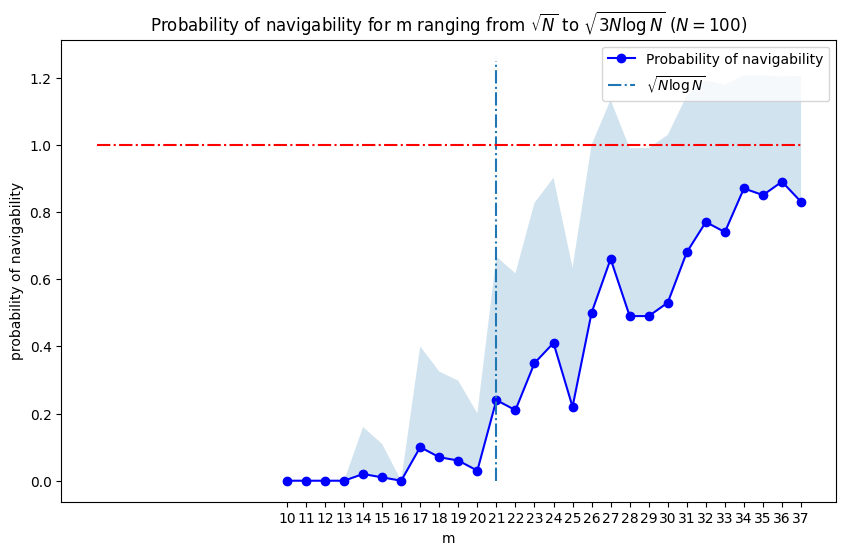

In [17]:
N = X.shape[0] 
ticks = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')

plt.figure(figsize=(10, 6))

plt.plot(ticks, SP, label='Probability of navigability', marker='o', color='b')
plt.fill_between(ticks, SP, SP + SP_STD, alpha = 0.2)
plt.vlines(np.floor(np.sqrt(N * np.log(N))), 0, 1.25, linestyles="dashdot", label = '$\sqrt{N \logN}$')
plt.hlines(1, 0, 37, linestyles="dashdot", colors='red')
plt.title('Probability of navigability for m ranging from $\sqrt{N}$ to $\sqrt{3N\logN}$ ($N = 100$)')
plt.xlabel('m')
plt.xticks(ticks)
plt.ylabel('probability of navigability')
plt.legend()
plt.show()

___________________

### Aris proposed routing

In [38]:
def secondDegreedy(s: int,
                   t: int,
                   x: np.array,
                   A: np.array,
                   two_hops = False
                   ):
        
    done = False
    j = s

    steps = 0

    while not done:
        
        if np.all(A[j] == 0):
            done = True

        else:
            neighs = np.where(A[j,:] == 1)[0]
            X_ = np.copy(x[neighs])
            hs = neighs[np.argsort(np.linalg.norm(X_ - x[t], axis = 1))[0:2]]
            
            if t in hs:
                j = t
                steps += 1
                done = True
                break

            neighs = np.row_stack(np.where(A[hs,:] == 1))
            X_ = np.copy(x[neighs[1,:]])
            neighs = np.row_stack([neighs, np.linalg.norm(X_ - x[t], axis = 1)])

            h = int(hs[int(neighs[0,np.argmin(neighs[2,:])])])

            if two_hops:
                h = int(int(neighs[1,np.argmin(neighs[2,:])]))

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):
                j = h
                steps += 1

            else:
                done = True


    return x[j], steps

In [76]:
def secondDegreedy_full(s: int,
                        t: int,
                        x: np.array,
                        A: np.array,
                        ):
        
    done = False
    j = s

    steps = 0

    while not done:
        
        if np.all(A[j] == 0):
            done = True

        else:
            neighs = np.where(A[j,:] == 1)[0]
            X_ = np.copy(x[neighs])
            
            if t in neighs:
                j = t
                steps += 1
                done = True
                break

            neighs = np.row_stack(np.where(A[neighs,:] == 1))
            X_ = np.copy(x[neighs[1,:]])
            neighs = np.row_stack([neighs, np.linalg.norm(X_ - x[t], axis = 1)])

            h = int(int(neighs[1,np.argmin(neighs[2,:])]))

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):
                j = h
                steps += 1

            else:
                done = True


    return x[j], steps

In [74]:
X = randomEnvironment(100, 5)

In [94]:
A = randomizedConstruction(X)

s = np.random.randint(0,X.shape[0])
t = np.random.randint(0,X.shape[0])

X1, steps = secondDegreedy_full(s, t, X, A)
print(np.all(X1 == X[t]))
print(steps)

True
1


### Aris proposed graph building

In [7]:
def randomizedPKConstruction(x: np.array,
                            ord = 2,
                            k = 10,
                            m = None,
                            scheme = 'paper'):

    n = x.shape[0]
    A = np.zeros((n,n))

    DBP = distanceBasedPermutation(x, ord)
    if not m:
        m = int(np.floor(np.sqrt(3 * n * np.log(n))))

    for i in range(n):

        # Deterministic step
        A[i, DBP[i, 1:m]] = 1
        
        # Randomized step
        if scheme == 'paper':
            S = int(np.ceil(3 * n * np.log(n)/m))
        else:
            S = m
        
        for i in range(S):
            
            # Power of k construction
            R = np.random.choice(np.concatenate([np.arange(0,i), np.arange(i+1,n)]), k)

            in_degrees = np.sum(A, axis = 0)[R]

            A[i, R[np.argmin(in_degrees)]] = 1

    return A


In [ ]:
A = randomizedPKConstruction(X)

s = np.random.randint(0,X.shape[0])
t = np.random.randint(0,X.shape[0])

X1, steps = secondDegreedy_full(s, t, X, A)
print(np.all(X1 == X[t]))
print(steps)

In [135]:
def secondSimo(N = 100,
               d = 4,
               M = 50,
               G = 10,
               k = 10,
               single = False,
               m = None,
               full = True):
    
    def edge_processing(edge, A, full = True):
        u = edge[0]
        v = edge[1]
        if full:

            D, steps_ = secondDegreedy_full(u, 
                                            v,
                                            X, 
                                            A)
        else:

            D, steps_ = secondDegreedy(u,
                                       v,
                                       X,
                                       A)
            
        if np.any(D != X[v]):
            successes[(u,v)] = 0
            steps[(u,v)] = np.inf
            
        else:
            successes[(u,v)] = 1
            steps[(u,v)] = steps_
    
    Ms = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')
    STEPS = np.zeros(Ms.shape[0])
    STEPS_SD = np.zeros(Ms.shape[0])

    SUCC_PROP = np.zeros(Ms.shape[0])
    SUCC_STD = np.zeros(Ms.shape[0])
    
    all_pairs = list(combinations(range(N),2))
    all_pairs_ = np.zeros((2,len(all_pairs)), dtype='int32')

    for i in range(len(all_pairs)):

        all_pairs_[0,i] = all_pairs[i][0]
        all_pairs_[1,i] = all_pairs[i][1]
    
    if not single:

        for m in tqdm(Ms):
            l = np.where(Ms == m)[0][0]
            avg_steps = np.zeros((G,M))
            successes_count = np.zeros((G,M))

            for j in range(G):

                X = randomEnvironment(N, d)

                for i in range(M):
                    
                    successes = {edge:0 for edge in all_pairs}
                    steps = {edge:0 for edge in all_pairs}

                    A = randomizedPKConstruction(X, 2, k, m, 'other')                
                    np.apply_along_axis(edge_processing, 0, all_pairs_, A = A, full = full)
                    
                    avg_steps[j,i] = np.mean(list(steps.values()))
                    successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
                
                STEPS[l] = np.mean(avg_steps)
                STEPS_SD[l] = np.std(avg_steps)
                
                SUCC_PROP[l] = np.mean(successes_count)
                SUCC_STD[l] = np.std(successes_count)

    else:
        
        avg_steps = np.zeros((G,M))
        successes_count = np.zeros((G,M))

        for j in range(G):

            X = randomEnvironment(N, d)

            for i in range(M):
                
                successes = {edge:0 for edge in all_pairs}
                steps = {edge:0 for edge in all_pairs}

                A = randomizedConstruction(X, 2, m, 'other')                
                np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                
                avg_steps[j,i] = np.mean(list(steps.values()))
                successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
        
        return Ms, np.mean(successes_count), np.std(successes_count), np.mean(avg_steps)

    return Ms, SUCC_PROP, SUCC_STD, STEPS

In [136]:
Ms, SP, SP_STD, steps = secondSimo(100, 4, 10, 10, 10)

  0%|          | 0/28 [00:00<?, ?it/s]c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 28/28 [36:40<00:00, 78.59s/it]


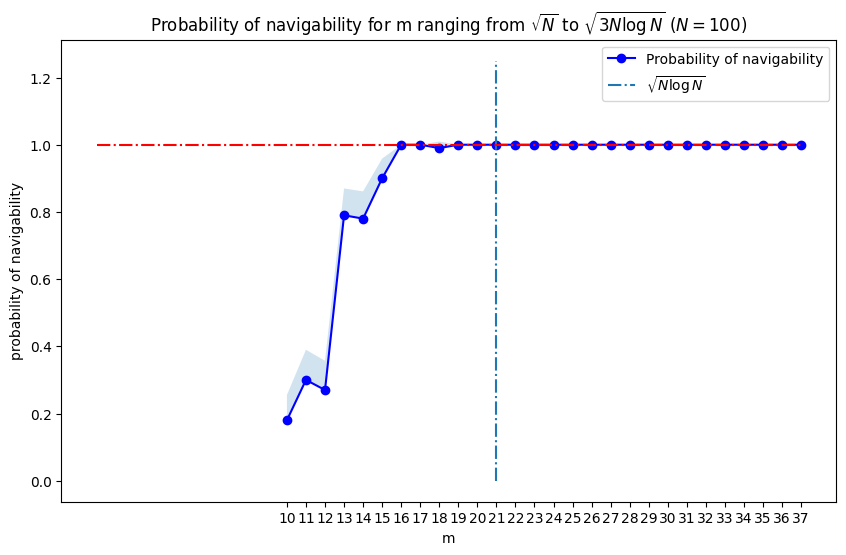

In [137]:
N = X.shape[0] 
ticks = Ms

SP_STD = 1.96* np.sqrt(SP*(1 - SP) / N)

plt.figure(figsize=(10, 6))

plt.plot(ticks, SP, label='Probability of navigability', marker='o', color='b')
plt.fill_between(ticks, SP, SP + SP_STD, alpha = 0.2)

plt.vlines(np.floor(np.sqrt(N * np.log(N))), 0, 1.25, linestyles="dashdot", label = '$\sqrt{N \logN}$')
plt.hlines(1, 0, 37, linestyles="dashdot", colors='red')
plt.title('Probability of navigability for m ranging from $\sqrt{N}$ to $\sqrt{3N\logN}$ ($N = 100$)')
plt.xlabel('m')
plt.xticks(ticks)
plt.ylabel('probability of navigability')
plt.legend()
plt.show()

__________

# Lower bounds analysis


In [23]:
def uniformD(N,
             C):
    
    d = C*np.log2(N)
    return np.random.choice([-1,1], size = (int(N),int(d)))

In [25]:
N = 100
X = uniformD(N,10)
len(set([tuple(row) for row in X])) == X.shape[0]

True

In [11]:
def thirdSimo(N = 100,
              d = 4,
              M = 50,
              G = 10,
              single = False,
              m = None):
    
    def edge_processing(edge, A):
        u = edge[0]
        v = edge[1]

        D, steps_ = greedyRouting(u, 
                                  v,
                                  X, 
                                  A)
        
        if np.any(D != X[v]):
            successes[(u,v)] = 0
            steps[(u,v)] = np.inf
            
        else:
            successes[(u,v)] = 1
            steps[(u,v)] = steps_
    
    Ms = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')
    STEPS = np.zeros(Ms.shape[0])
    STEPS_SD = np.zeros(Ms.shape[0])

    SUCC_PROP = np.zeros(Ms.shape[0])
    SUCC_STD = np.zeros(Ms.shape[0])
    
    all_pairs = list(combinations(range(N),2))
    all_pairs_ = np.zeros((2,len(all_pairs)), dtype='int32')

    for i in range(len(all_pairs)):

        all_pairs_[0,i] = all_pairs[i][0]
        all_pairs_[1,i] = all_pairs[i][1]
    
    if not single:

        for m in tqdm(Ms):
            
            l = np.where(Ms == m)[0][0] 
            avg_steps = np.zeros((G,M))
            successes_count = np.zeros((G,M))

            for j in range(G):

                X = uniformD(N, 10)

                for i in range(M):
                    
                    successes = {edge:0 for edge in all_pairs}
                    steps = {edge:0 for edge in all_pairs}

                    A = randomizedConstruction(X, 2, m, 'other')                
                    np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                    
                    avg_steps[j,i] = np.mean(list(steps.values()))
                    successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
                    
                STEPS[l] = np.mean(avg_steps)
                STEPS_SD[l] = np.std(avg_steps)
                
                SUCC_PROP[l] = np.mean(successes_count)
                SUCC_STD[l] = np.std(successes_count)

    else:
        
        avg_steps = np.zeros((G,M))
        successes_count = np.zeros((G,M))

        for j in range(G):

            X = randomEnvironment(N, d)

            for i in range(M):
                
                successes = {edge:0 for edge in all_pairs}
                steps = {edge:0 for edge in all_pairs}

                A = randomizedConstruction(X, 2, m, 'other')                
                np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                
                avg_steps[j,i] = np.mean(list(steps.values()))
                successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
        
        return np.mean(successes_count), np.std(successes_count), np.mean(avg_steps)

    return SUCC_PROP, SUCC_STD, STEPS

In [68]:
SP, SP_STD, steps = thirdSimo(100, 4, 10, 10)

100%|██████████| 28/28 [28:07<00:00, 60.27s/it]


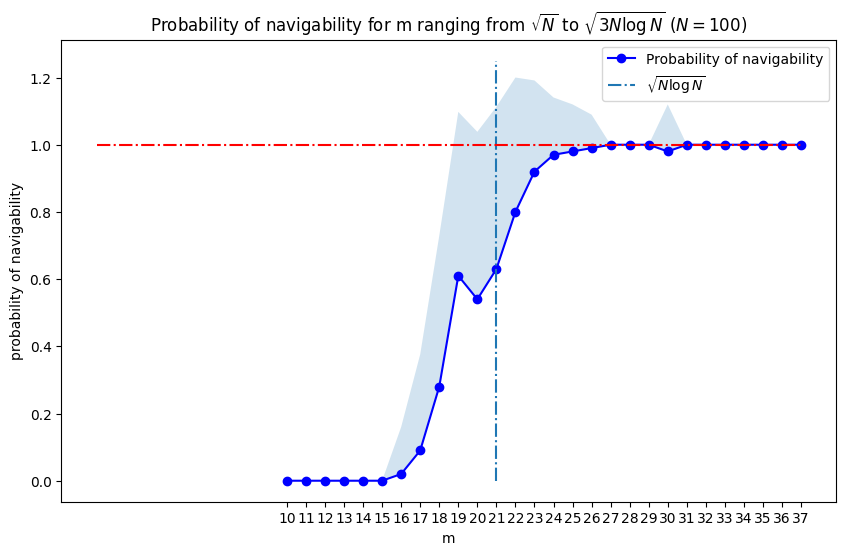

In [69]:
N = X.shape[0] 
ticks = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')

plt.figure(figsize=(10, 6))

plt.plot(ticks, SP, label='Probability of navigability', marker='o', color='b')
plt.fill_between(ticks, SP, SP + SP_STD, alpha = 0.2)
plt.vlines(np.floor(np.sqrt(N * np.log(N))), 0, 1.25, linestyles="dashdot", label = '$\sqrt{N \logN}$')
plt.hlines(1, 0, 37, linestyles="dashdot", colors='red')
plt.title('Probability of navigability for m ranging from $\sqrt{N}$ to $\sqrt{3N\logN}$ ($N = 100$)')
plt.xlabel('m')
plt.xticks(ticks)
plt.ylabel('probability of navigability')
plt.legend()
plt.show()

In [12]:
# Greedy routing algorithm relaxed - we can visit further nodes

def greedyRoutingRelax(s: int,
                       t: int,
                       x: np.array,
                       A: np.array,
                       MAX_WORSE = 50
                       ):
    
    done = False
    j = s

    steps = 0
    worse = 0
    
    while not done and worse < MAX_WORSE:
        if np.all(A[j] == 0) or j == t:
            done = True
            break

        else:

            neighs = np.where(A[j,:] == 1)[0]
            X_ = np.copy(x[neighs])
            h = neighs[np.argmin(np.linalg.norm(X_ - x[t], axis = 1))]

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):

                j = h
                steps += 1

                if j == t:

                    done = True
                    break
            
            else:

                # Visit a further node among the neighs
                j = np.random.choice(neighs)
                worse += 1
                steps += 1

  
    return j, steps, worse

In [32]:
X = uniformD(100, 1)
A = randomizedConstruction(X)

s = np.random.randint(0,X.shape[0])
t = np.random.randint(0,X.shape[0])

print(s,t)

start = timeit.default_timer()
X1, steps, worse = greedyRoutingRelax(s, t, X, A)
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(X1,t)
print(X1 == t)
print(steps)
print(worse)

start = timeit.default_timer()
X1, steps = greedyRouting(s, t, X, A)
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(X1,t)
print(X1 == t)
print(steps)


72 76
Time:  0.004778499947860837
21 76
False
99
50
Time:  0.00018909992650151253
51 76
False
1


In [35]:
def fourthSimo(N = 100,
                d = 10,
                M = 50,
                G = 10,
                single = False,
                m = None):
    
    def edge_processing(edge, A, X):
        u = edge[0]
        v = edge[1]

        D, steps_, worse_ = greedyRoutingRelax(u, 
                                               v,
                                               X, 
                                               A)

        if D != v:
            successes[(u,v)] = 0
            steps[(u,v)] = np.inf
            worse[(u,v)] = worse_

        else:
            successes[(u,v)] = 1
            steps[(u,v)] = steps_
            worse[(u,v)] = worse_

    Ms = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')

    STEPS = np.zeros(Ms.shape[0])
    STEPS_SD = np.zeros(Ms.shape[0])

    WORSE = np.zeros(Ms.shape[0])
    WORSE_SD = np.zeros(Ms.shape[0])

    SUCC_PROP = np.zeros(Ms.shape[0])
    SUCC_STD = np.zeros(Ms.shape[0])
    
    all_pairs = list(combinations(range(N),2))
    all_pairs_ = np.zeros((2,len(all_pairs)), dtype='int32')

    for i in range(len(all_pairs)):

        all_pairs_[0,i] = all_pairs[i][0]
        all_pairs_[1,i] = all_pairs[i][1]
    
    if not single:

        for m in tqdm(Ms):
            
            l = np.where(Ms == m)[0][0] 
            avg_steps = np.zeros((G,M))
            avg_worse = np.zeros((G,M))
            successes_count = np.zeros((G,M))

            for j in range(G):
                
                X = uniformD(N, d)

                for i in range(M):
                    steps = {edge:0 for edge in all_pairs}
                    worse = {edge:0 for edge in all_pairs}
                    successes = {edge:0 for edge in all_pairs}

                    A = randomizedConstruction(X, 2, m, 'other')                
                    np.apply_along_axis(edge_processing, 0, all_pairs_, X = X, A = A)
                    
                    avg_steps[j,i] = np.mean(list(steps.values()))
                    avg_worse[j,i] = np.mean(list(worse.values()))
                    successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)

                STEPS[l] = np.mean(avg_steps)
                STEPS_SD[l] = np.std(avg_steps)
                
                WORSE[l] = np.mean(avg_worse)
                WORSE_SD[l] = np.std(avg_worse)

                SUCC_PROP[l] = np.mean(successes_count)
                SUCC_STD[l] = np.std(successes_count)

    else:
        
        avg_steps = np.zeros((G,M))
        successes_count = np.zeros((G,M))

        for j in range(G):

            X = randomEnvironment(N, d)

            for i in range(M):
                
                successes = {edge:0 for edge in all_pairs}
                steps = {edge:0 for edge in all_pairs}

                A = randomizedConstruction(X, 2, m, 'other')                
                np.apply_along_axis(edge_processing, 0, all_pairs_, A = A)
                
                avg_steps[j,i] = np.mean(list(steps.values()))
                successes_count[j,i] = np.all(np.array(list(successes.values())) == 1)
        
        return np.mean(successes_count), np.std(successes_count), np.mean(avg_steps)

    return SUCC_PROP, SUCC_STD, STEPS, WORSE

In [15]:
SP, SP_STD, steps, worse = fourthSimo(100, 10, 10, 5)

100%|██████████| 28/28 [09:12<00:00, 19.75s/it]


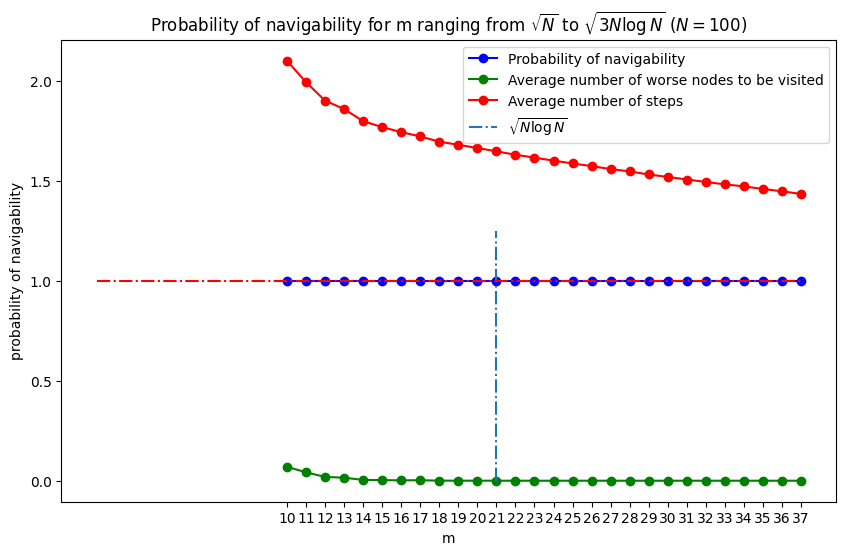

In [21]:
N = X.shape[0] 
ticks = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')

plt.figure(figsize=(10, 6))

plt.plot(ticks, SP, label='Probability of navigability', marker='o', color='b')
plt.plot(ticks, worse, label='Average number of worse nodes to be visited', marker='o', color='g')
plt.plot(ticks, steps, label='Average number of steps', marker='o', color='r')

plt.fill_between(ticks, SP, SP + SP_STD, alpha = 0.2)
plt.vlines(np.floor(np.sqrt(N * np.log(N))), 0, 1.25, linestyles="dashdot", label = '$\sqrt{N \logN}$')
plt.hlines(1, 0, 37, linestyles="dashdot", colors='red')
plt.title('Probability of navigability for m ranging from $\sqrt{N}$ to $\sqrt{3N\logN}$ ($N = 100$)')
plt.xlabel('m')
plt.xticks(ticks)
plt.ylabel('probability of navigability')
plt.legend()
plt.show()

In [39]:
SP = {d:None for d in range(5,11)}
SP_STD = {d:None for d in range(5,11)}
steps = {d:None for d in range(5,11)}
worse = {d:None for d in range(5,11)}

for d in range(5,11):
    SP[d], SP_STD[d], steps[d], worse[d] = fourthSimo(100, d, 10, 5)

100%|██████████| 28/28 [09:25<00:00, 20.21s/it]


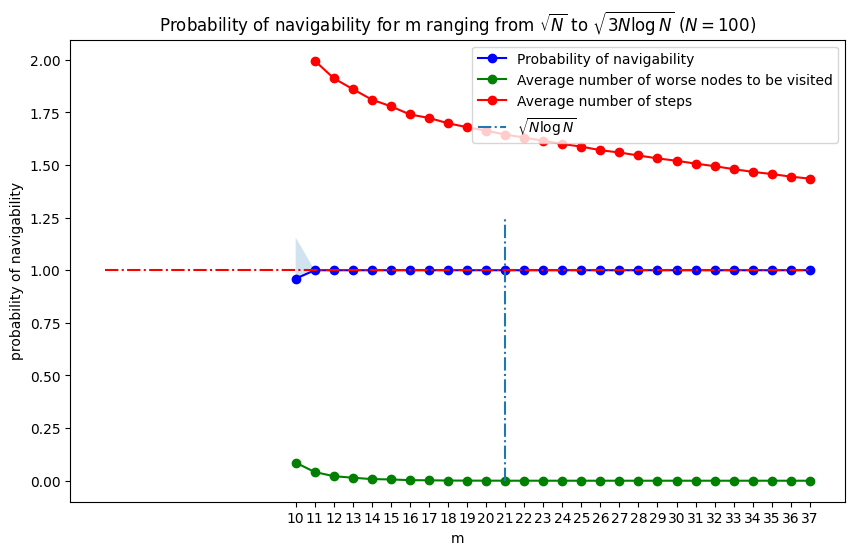

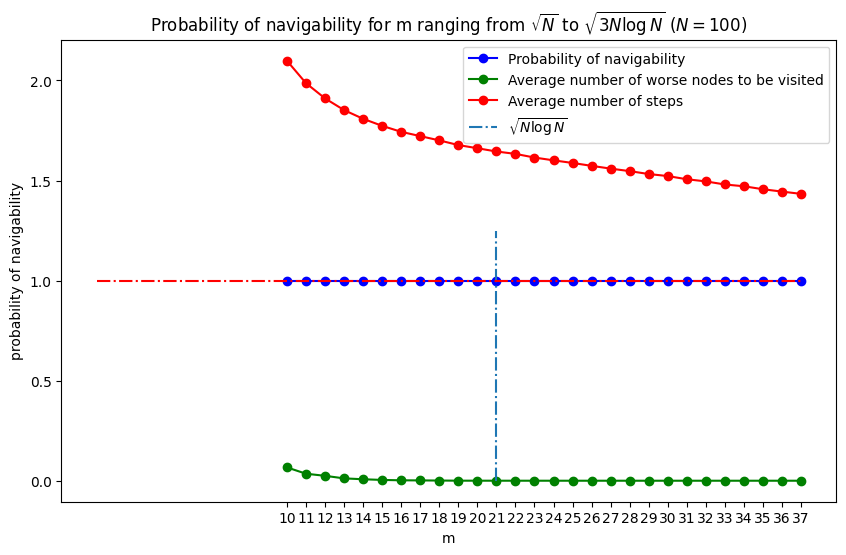

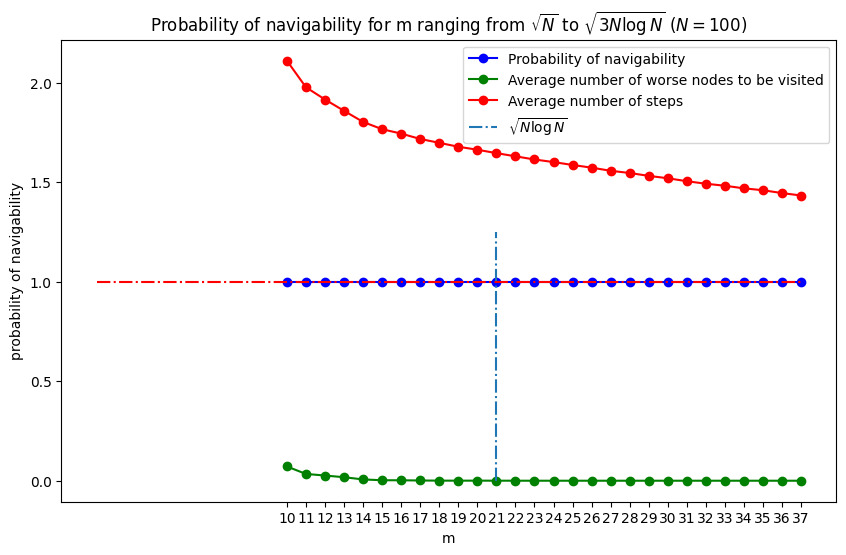

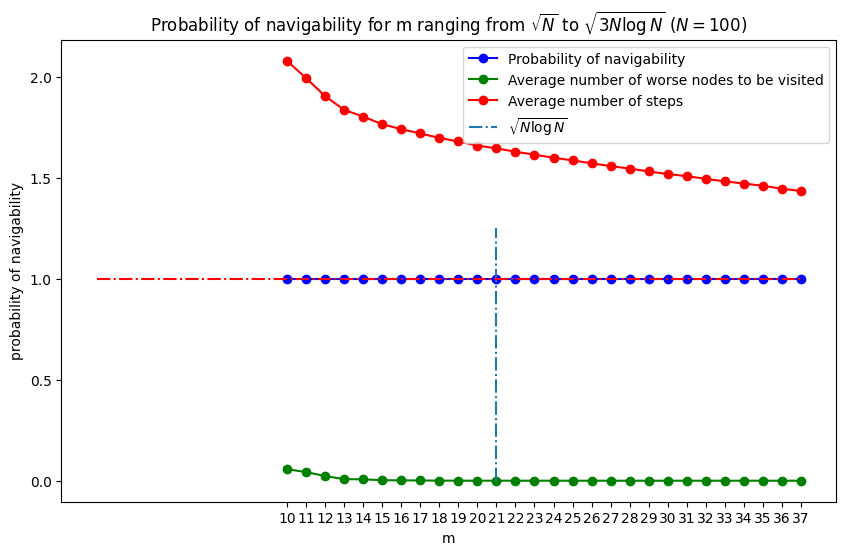

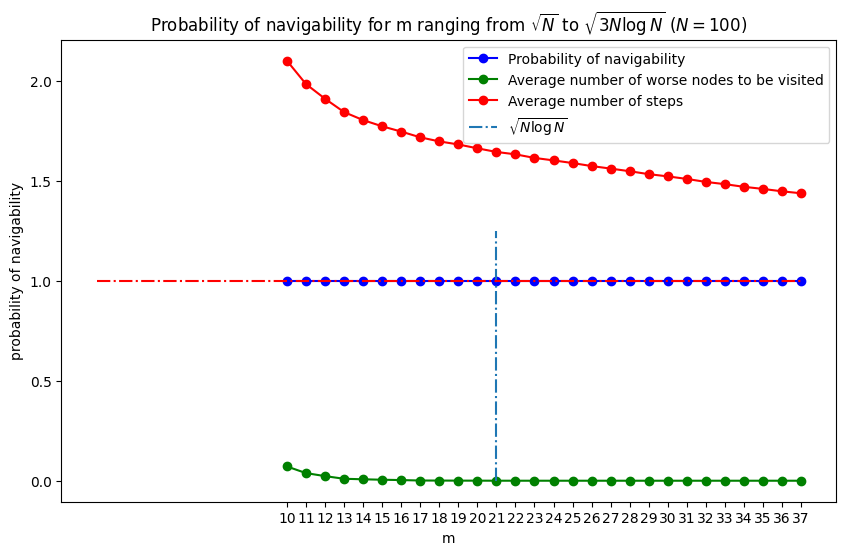

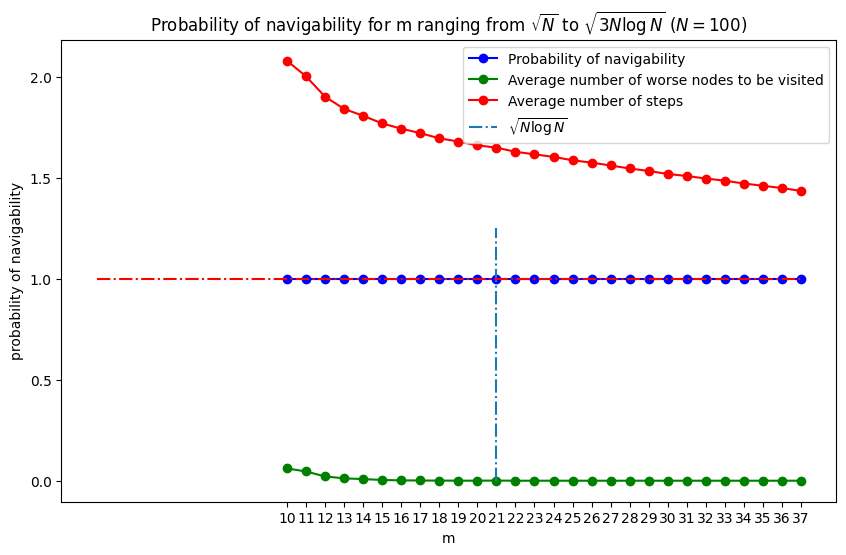

In [40]:
for d in range(5,11):
    N = X.shape[0] 
    ticks = np.arange(np.sqrt(N),np.sqrt(3 * N * np.log(N)), dtype='int32')

    plt.figure(figsize=(10, 6))

    plt.plot(ticks, SP[d], label='Probability of navigability', marker='o', color='b')
    plt.plot(ticks, worse[d], label='Average number of worse nodes to be visited', marker='o', color='g')
    plt.plot(ticks, steps[d], label='Average number of steps', marker='o', color='r')

    plt.fill_between(ticks, SP[d], SP[d] + SP_STD[d], alpha = 0.2)
    plt.vlines(np.floor(np.sqrt(N * np.log(N))), 0, 1.25, linestyles="dashdot", label = '$\sqrt{N \logN}$')
    plt.hlines(1, 0, 37, linestyles="dashdot", colors='red')
    plt.title('Probability of navigability for m ranging from $\sqrt{N}$ to $\sqrt{3N\logN}$ ($N = 100$)')
    plt.xlabel('m')
    plt.xticks(ticks)
    plt.ylabel('probability of navigability')
    plt.legend()
    plt.show()